In [1]:
library(tidyverse)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

In [3]:
ppi_df <- read_tsv('../../data/3.all_nodes/ppi.tsv.xz') 

ppi_degree_df <- ppi_df %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new)

ppi_vis_dists <- ppi_degree_df %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(name = 'ppi')

head(ppi_vis_dists, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_integer(),
  id_b = col_integer(),
  train = col_integer(),
  test_recon = col_integer(),
  test_new = col_integer()
)


id,network_type,degree,name
0,biased,55,ppi
1,biased,3,ppi


In [4]:
tftg_df <- read_tsv('../../data/3.all_nodes/tftg.tsv.xz')

tftg_degree_df <- tftg_df %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id_side", "id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new)

tftg_vis_dists <- tftg_degree_df %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(name = id_side %>% recode(id_a = 'tftg_source', id_b = 'tftg_target')) %>%
    ungroup() %>%
    select(-id_side)

head(tftg_vis_dists, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_integer(),
  id_b = col_integer(),
  train = col_integer(),
  test_recon = col_integer(),
  test_new = col_integer()
)


id,network_type,degree,name
0,biased,13,tftg_source
1,biased,67,tftg_source


In [5]:
biorxiv_df <- read_tsv('../../data/3.all_nodes/biorxiv.tsv.xz')

biorxiv_degree_df <- biorxiv_df %>%
    select(-starts_with('name')) %>%
    gather('id_side', 'id', id_a:id_b) %>%
    group_by(.dots=c("id")) %>%
    summarize_at(vars(train, test_new), funs(sum)) %>%
    rename(biased=train, unbiased=test_new)

biorxiv_vis_dists <- biorxiv_degree_df %>%
    gather('network_type', 'degree', biased:unbiased) %>%
    mutate(
        name = 'co_author',
        network_type = network_type %>% recode(biased = "<2018", unbiased = ">=2018")
    )

head(biorxiv_vis_dists, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_integer(),
  id_b = col_integer(),
  train = col_integer(),
  test_recon = col_integer(),
  test_new = col_integer()
)


id,network_type,degree,name
0,<2018,12,co_author
2,<2018,8,co_author


In [6]:
vis_df <- bind_rows(ppi_vis_dists, tftg_vis_dists, biorxiv_vis_dists) %>%
    mutate(
        name = name %>% recode_factor(
            ppi = 'PPI', 
            tftg_source = 'TFTG - Transcription factor', 
            tftg_target = 'TFTG - Target gene',
            co_author = 'Co-authorship',
        ),
        network_type = network_type %>% recode_factor(
            biased = 'Literature-derived',
            unbiased = 'Systematic',
        )
    )

head(vis_df, 2)

id,network_type,degree,name
0,Literature-derived,55,PPI
1,Literature-derived,3,PPI


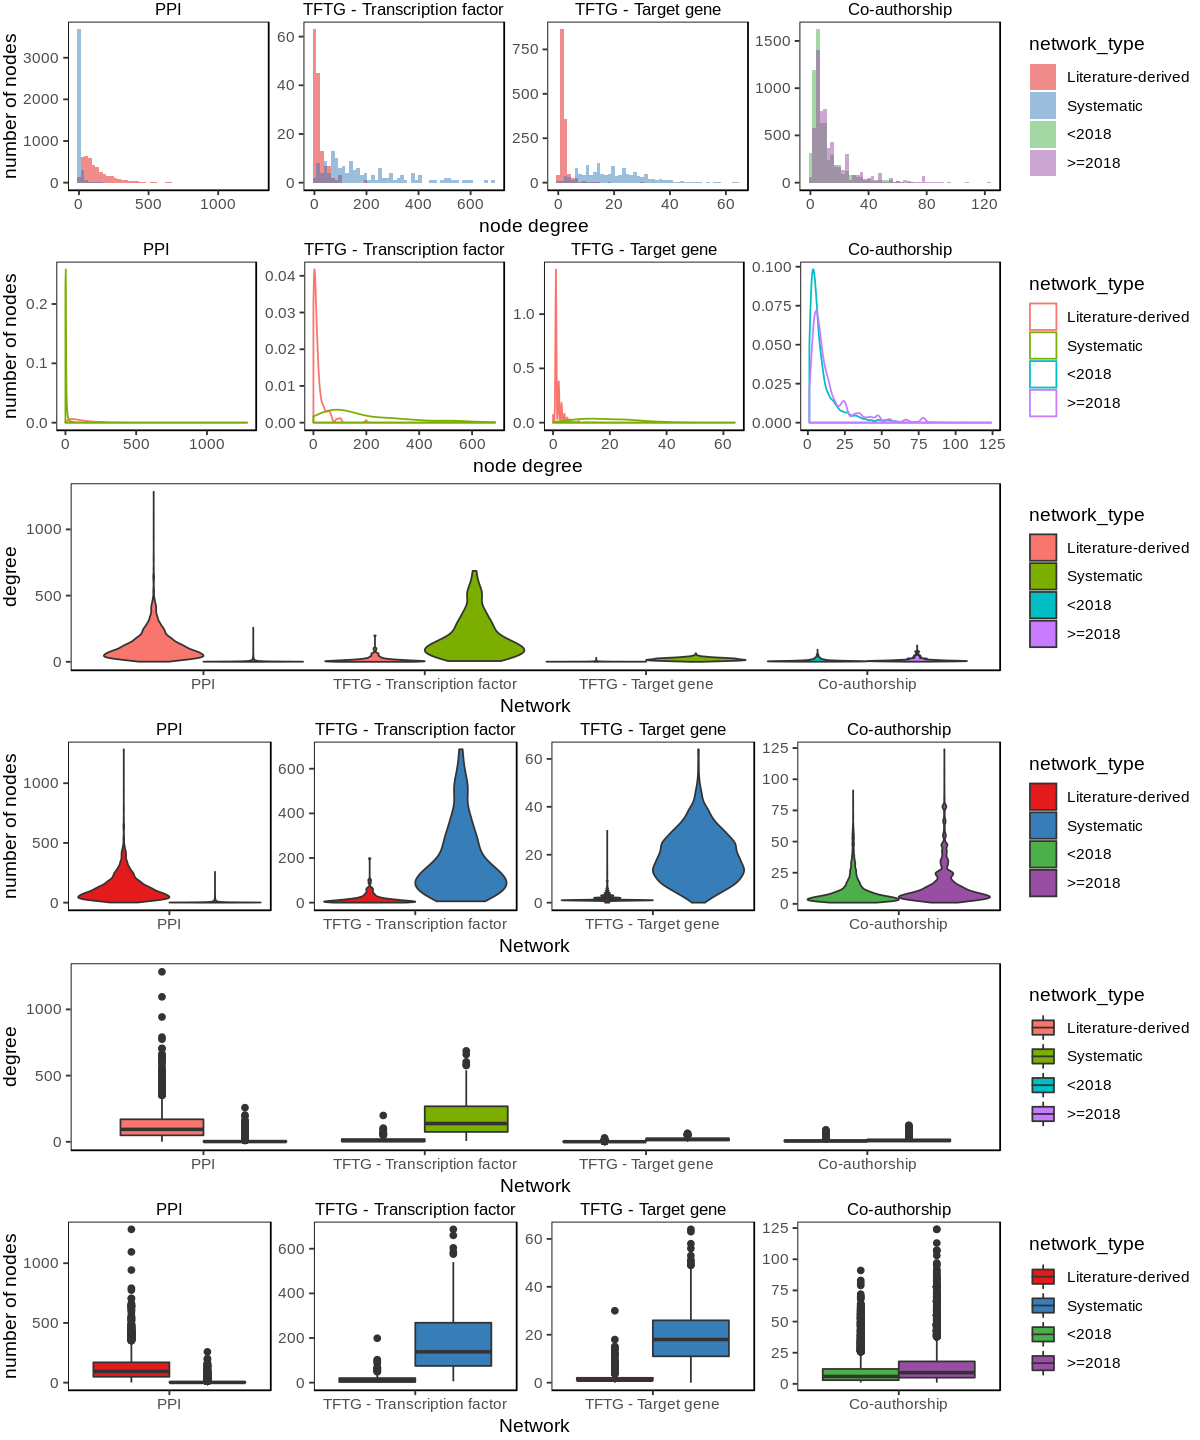

In [7]:
options(repr.plot.width=10, repr.plot.height=12)

histogram_dists <- (
    ggplot(vis_df, aes(x = degree, fill=network_type))
    + geom_histogram(position = position_identity(), alpha = 0.5, bins = 50)
    + facet_wrap("name", scales='free', nrow=1)
    + scale_fill_brewer(palette = "Set1")
    + ylab('number of nodes')
    + xlab('node degree')
    + theme_zietzm()
)

kde_dists <- (
    ggplot(vis_df, aes(x = degree, color=network_type))
    + geom_density(position = position_identity(), alpha = 0.5)
    + facet_wrap("name", scales='free', nrow=1)
    + scale_fill_brewer(palette = "Set1")
    + ylab('number of nodes')
    + xlab('node degree')
    + theme_zietzm()
)

violin <- (
    ggplot(vis_df, aes(x = name, y = degree, fill = network_type))
    + geom_violin(scale = 'width')
    + xlab('Network')
    + theme_zietzm()
)

violin_facet <- (
    ggplot(vis_df, aes(x = name, y = degree, fill = network_type))
    + geom_violin(scale = 'width')
    + facet_wrap("name", scales='free', nrow=1)
    + scale_fill_brewer(palette = "Set1")
    + ylab('number of nodes')
    + xlab('Network')
    + theme_zietzm()
)

box <- (
    ggplot(vis_df, aes(x = name, y = degree, fill = network_type))
    + geom_boxplot(position = 'dodge')
    + xlab('Network')
    + theme_zietzm()
)

box_facet <- (
    ggplot(vis_df, aes(x = name, y = degree, fill = network_type))
    + geom_boxplot(position = 'dodge')
    + facet_wrap("name", scales='free', nrow=1)
    + scale_fill_brewer(palette = "Set1")
    + ylab('number of nodes')
    + xlab('Network')
    + theme_zietzm()
)

ggsave(plot = histogram_dists, filename = '../../img/1_degree_bias/histogram.png', dpi = 500,
       width=10, height=3)

grid.arrange(histogram_dists, kde_dists, violin, violin_facet, box, box_facet, ncol = 1)